# CARLA System Identification

Based on the data that are obtained from the CARLA Simulator, the dynamics of the system will be identified using the function below

$$
\displaystyle{\dot{v} = a_1 + a_2v + a_3v^2 + b_1 u_{11} + b_2 e^{(b_3v + b_4u_{12})}u_{13} + c_1u_{21} + c_2 e^{(c_3v + c_4u_{22})}u_{23}}
$$

Where $\dot{v}$ is the acceleration of the vehicle, $u_{1p}$ is the throttle with time delay $d_{1p}$, $b_{1p}$ is the brake with time delay $d_{2p}$, and $a_1, a_2, a_3, b_1, b_2, b_3, b_4, c_1, c_2, c_3, c_4$ are constants. The equations are based on physical properties that affects the vehicle. Based on those properties there are constraints that needs to be acknowledged by the system.

* The friction that resists the vehicle movement, i.e $a_1, a_2 < 0$
* The friction is zero when the vehicle is not moving, i.e $a_1$ needs to be reset to zero when $v$ is zero
* The drag force that resists the vehicle movement, i.e $a_3 < 0$
* The throttle that drives the vehicle, i.e $b_1, b_2 > 0$
* The brake that resists the vehicle movement, i.e $c_1, c_2 < 0$
* The time delay must not be negative, i.e $d_{11}, d_{12}, d_{13}, d_{21}, d_{22}, d_{23} > 0$

In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import jit, njit, types, vectorize, prange
from numba import jitclass, int32, float32, int64, float64
from multiprocessing import Pool
from os import listdir
from os.path import isfile, join
import random
from sklearn.cluster import KMeans

## CARLA Simulation Data

In [2]:
gt = {}
i = 1
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data0.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data0.csv')['v'].values)
i = 2
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data1.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data1.csv')['v'].values)
i = 3
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data2.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data2.csv')['v'].values)
i = 4
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data4.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data4.csv')['v'].values)
i = 5
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data5.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data5.csv')['v'].values)
i = 6
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data6.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data6.csv')['v'].values)
i = 7
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data8.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data8.csv')['v'].values)
i = 8
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data9.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data9.csv')['v'].values)
i = 9
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data10.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data10.csv')['v'].values)
i = 10
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/data11.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/data11.csv')['v'].values)
i = 11
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/exp-data3.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/exp-data3.csv')['v'].values)
i = 12
gt[i] = {}
gt[i]['t'] = np.array(pd.read_csv('post_processing_data/exp-data7.csv')['t'].values)
gt[i]['v'] = np.array(pd.read_csv('post_processing_data/exp-data7.csv')['v'].values)

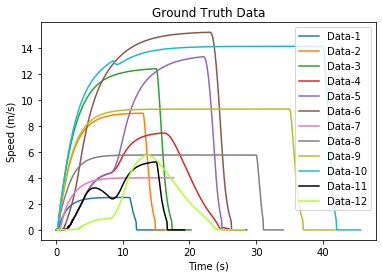

In [3]:
plt.clf()
for i in range(1,13):
    if i == 11:
        plt.plot(gt[i]['t'], gt[i]['v'], label='Data-{}'.format(i), color='black')
    elif i == 12:
        
        plt.plot(gt[i]['t'], gt[i]['v'], label='Data-{}'.format(i), color='greenyellow')
    else:
        plt.plot(gt[i]['t'], gt[i]['v'], label='Data-{}'.format(i))
plt.legend()
plt.title('Ground Truth Data')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.savefig('Image/ground_truth', dpi=600)

In [4]:
path = 'post_processing_data'
files = [x for x in listdir(path) if isfile(join(path, x))]
df = {}
for x in files:
    df[x] = pd.read_csv(path + '/' + x)

Assign the ground truth data to each $t$, $u$, and $v$

In [5]:
i = 0
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t0 = np.array(df[x].t).astype('float64')
u0 = np.array([throttle, brake]).T.astype('float64')
v0 = np.array(df[x].v).astype('float64')

i = 1
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t1 = np.array(df[x].t).astype('float64')
u1 = np.array([throttle, brake]).T.astype('float64')
v1 = np.array(df[x].v).astype('float64')

i = 2
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t2 = np.array(df[x].t).astype('float64')
u2 = np.array([throttle, brake]).T.astype('float64')
v2 = np.array(df[x].v).astype('float64')

i = 3
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t3 = np.array(df[x].t).astype('float64')
u3 = np.array([throttle, brake]).T.astype('float64')
v3 = np.array(df[x].v).astype('float64')

i = 4
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t4 = np.array(df[x].t).astype('float64')
u4 = np.array([throttle, brake]).T.astype('float64')
v4 = np.array(df[x].v).astype('float64')

i = 5
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t5 = np.array(df[x].t).astype('float64')
u5 = np.array([throttle, brake]).T.astype('float64')
v5 = np.array(df[x].v).astype('float64')

i = 6
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t6 = np.array(df[x].t).astype('float64')
u6 = np.array([throttle, brake]).T.astype('float64')
v6 = np.array(df[x].v).astype('float64')

i = 7
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t7 = np.array(df[x].t).astype('float64')
u7 = np.array([throttle, brake]).T.astype('float64')
v7 = np.array(df[x].v).astype('float64')

i = 8
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t8 = np.array(df[x].t).astype('float64')
u8 = np.array([throttle, brake]).T.astype('float64')
v8 = np.array(df[x].v).astype('float64')

i = 9
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t9 = np.array(df[x].t).astype('float64')
u9 = np.array([throttle, brake]).T.astype('float64')
v9 = np.array(df[x].v).astype('float64')

i = 10
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t10 = np.array(df[x].t).astype('float64')
u10 = np.array([throttle, brake]).T.astype('float64')
v10 = np.array(df[x].v).astype('float64')

i = 11
x = files[i]
throttle = df[x].throttle
brake = df[x].brake
t11 = np.array(df[x].t).astype('float64')
u11 = np.array([throttle, brake]).T.astype('float64')
v11 = np.array(df[x].v).astype('float64')

Test the variables, if an error occures then the data needs to be checked again.

In [6]:
_ = t0 + u0[:,0] + v0
_ = t1 + u1[:,0] + v1
_ = t2 + u2[:,0] + v2
_ = t3 + u3[:,0] + v3
_ = t4 + u4[:,0] + v4
_ = t5 + u5[:,0] + v5
_ = t6 + u6[:,0] + v6
_ = t7 + u7[:,0] + v7
_ = t8 + u8[:,0] + v8
_ = t9 + u9[:,0] + v9
_ = t10 + u10[:,0] + v10
_ = t11 + u11[:,0] + v11

## Functions

### Generate Particles

In [7]:
def generate_particles(num, params, rng):
    part = np.zeros((num, params))
    for i in range(params):
        lim = rng[i]
        part[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return part

Generate Particles

In [8]:
num = 20

r_a1 = [0., -2.]
r_a2 = [0., -2.]
r_a3 = [0., -2.]
r_b1 = [0., 2.]
r_b2 = [0., 2.]
r_b3 = [-2., 2.]
r_b4 = [-2., 2.]
r_c1 = [0., -2.]
r_c2 = [0., -2.]
r_c3 = [-2., 2.]
r_c4 = [-2., 2.]
r_td11 = [5, 25]
r_td12 = [5, 25]
r_td13 = [5, 25]
r_td21 = [0, 10]
r_td22 = [0, 10]
r_td23 = [0, 10]
rng = [r_a1, r_a2, r_a3,
       r_b1, r_b2, r_b3, r_b4,
       r_c1, r_c2, r_c3, r_c4,
       r_td11, r_td12, r_td13,
       r_td21, r_td22, r_td23
      ]
params = len(rng)

In [9]:
pos = generate_particles(num, params, rng)

### Delayed Control Signal

In [10]:
@njit
def delayed_control_signal(i, u, u_list, td):
    if i < td:
        ut = 0.0
    else:
        if td == 0:
            ut = u
        else:
            ut = u_list[i-td]
    return ut

_ = delayed_control_signal(1, 0.1, np.array([0.1, 0.2]), 0)

### Evaluation Function

In [11]:
@njit
def ev_func(t, u, param):
    a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param
    td11 = int(np.around(td11))
    td12 = int(np.around(td12))
    td13 = int(np.around(td13))
    td21 = int(np.around(td21))
    td22 = int(np.around(td22))
    td23 = int(np.around(td23))

    u1_list = np.empty(t.shape)
    u2_list = np.empty(t.shape)
    out = np.empty(t.shape)
    y = 0.0
    for i in range(t.shape[0]):
        if i == 0:
            dt = t[1] - t[0]
        else:
            dt = t[i] - t[i-1]
            
        u1, u2 = u[i]        
        u11t = delayed_control_signal(i, u1, u1_list, td11)
        u12t = delayed_control_signal(i, u1, u1_list, td12)
        u13t = delayed_control_signal(i, u1, u1_list, td13)
        u21t = delayed_control_signal(i, u2, u2_list, td21)
        u22t = delayed_control_signal(i, u2, u2_list, td22)
        u23t = delayed_control_signal(i, u2, u2_list, td23)
        
        temp = 0.
        if y != 0.:
            temp = a1
                    
        y_dot = temp + a2 * y + a3 * y**2 + b1 * u11t + b2 * np.exp(b3 * y + b4 * u12t) * u13t + c1 * u21t + c2 * np.exp(c3 * y + c4 * u22t) * u23t
        
        y += y_dot * dt
        if y < 0.0:
            y = 0.0

        u1_list[i] = u1
        u2_list[i] = u2
        out[i] = y

    return out

_ = ev_func(np.arange(10, dtype=float), np.random.randn(10,2), np.ones(17))

### Constrains

In [12]:
@njit
def constrain(param):
    a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param
    if a1 > 0. or a2 > 0. or a3 > 0. or b1 < 0. or b2 < 0. or c1 > 0. or c2 > 0. or np.around(td11)<0 or np.around(td12)<0 or np.around(td13)<0 or np.around(td21)<0 or np.around(td22)<0 or np.around(td23)<0:
        return False
    else:
        return True
    
_ = constrain(np.random.randn(17))

### Cost Function

In [17]:
@njit
def cost_(t, u, v, param):
    error = v - ev_func(t, u, param)
    #cost = np.dot(error.T, error)
    cost = np.mean(error**2)
    return cost

_ = cost_(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(17))

In [21]:
@njit
def cost(param):
    loss = np.Inf
    if constrain(param):
        loss = 0.
        m = 0.
        
        loss += cost_(t0, u0, v0, param)
        loss += cost_(t1, u1, v1, param)
        loss += cost_(t2, u2, v2, param)
        loss += cost_(t3, u3, v3, param)
        loss += cost_(t4, u4, v4, param)
        loss += cost_(t5, u5, v5, param)
        loss += cost_(t6, u6, v6, param)
        loss += cost_(t7, u7, v7, param)
        loss += cost_(t8, u8, v8, param)
        loss += cost_(t9, u9, v9, param)
        loss += cost_(t10, u10, v10, param)
        loss += cost_(t11, u11, v11, param)
                
        '''m += t0.shape[0]
        m += t1.shape[0]
        m += t2.shape[0]
        m += t3.shape[0]
        m += t4.shape[0]
        m += t5.shape[0]
        m += t6.shape[0]
        m += t7.shape[0]
        m += t8.shape[0]
        m += t9.shape[0]
        m += t10.shape[0]
        m += t11.shape[0]'''
        
        loss = loss / param.shape[0]
        
    return loss

_ = cost(np.ones(17))

### Accuracy

In [22]:
@njit
def accuracy(t, u, v, param):
    error = v - ev_func(t, u, param)
    numerator = np.linalg.norm(error)
    denumerator = np.linalg.norm(v - np.mean(v))
    acc = 1.0 - numerator / denumerator
    return acc
_ = accuracy(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(17))

### MSE

In [23]:
@njit
def mean_squared_error(t, u, v, param):
    error = v - ev_func(t, u, param)
    out = np.mean(error**2)
    return out
_ = mean_squared_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(17))

### MAAE

In [24]:
@njit
def maximum_absolute_error(t, u, v, param):
    error = v - ev_func(t, u, param)
    out = np.max(np.abs(error))
    return out
_ = maximum_absolute_error(np.arange(10, dtype=float), np.random.randn(10,2), np.random.randn(10), np.ones(17))

### PSO Algorithm

In [25]:
@njit
def PSO(c_func, n_param, particles, part, iterate_max):
    # Define the constants
    c1 = 2.05
    c2 = 2.05
    psi = c1+c2
    w = 2*psi/(2-psi-np.sqrt(psi*(psi-4)))
    iterate = 0
    
    # Setup the initial conditions for position and velocity arrays
    ppos_vector = part
    pbest_pos = ppos_vector
    pfit_value = np.ones(particles) * 1e100
    gbest_pos = np.zeros(n_param)
    gfit_value = 1e100
    pvel_vector = np.zeros((particles, n_param))
    
    # First loop for assigning the fitness value using the cost function
    for i in range(particles):
        # Check the position of individual and group value using the evaluation function
        cost_func = c_func(ppos_vector[i])
        
        # Update each values using the cost functions
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
        
    # Second loop for implementing the PSO Algorithm
    while (iterate < iterate_max):
        for i in range(particles):
            # Update the velocity and position vector
            pvel_vector[i] = w*pvel_vector[i] + c1*random.random()*(pbest_pos[i]-ppos_vector[i]) + c2*random.random()*(gbest_pos-ppos_vector[i])
            ppos_vector[i] = pvel_vector[i] + ppos_vector[i]
            
            cost_func = c_func(ppos_vector[i])
            
            # Update each values using the cost functions
            if(pfit_value[i] > cost_func):
                pfit_value[i] = cost_func
                pbest_pos[i] = np.copy(ppos_vector[i])
                
            if(gfit_value > cost_func):
                gfit_value = cost_func
                gbest_pos = np.copy(ppos_vector[i])
        
        iterate = iterate+1
        print("Iteration: ", iterate, " | Global best cost: ", c_func(gbest_pos))
    
    gbest_loss = c_func(gbest_pos)
    
    print("The best position for each parameter: ", gbest_pos, " with ", iterate, " iteration.")
    return ppos_vector, gbest_pos, gbest_loss

_ = PSO(cost, 17, 20, pos, 1)

Iteration:  1  | Global best cost:  18.11465929382213
The best position for each parameter:  [-0.0275597  -0.6505727  -1.34106416  0.91848849  2.5296284   0.08299527
  2.43874364 -0.2142153  -1.64643342 -0.5085729  -0.27819    13.64249554
 21.93436245  2.83232041  8.78838381  1.74965028  5.72608663]  with  1  iteration.


### APSO Algorithm

In [26]:
@njit
def APSO(c_func, n_param, particles, part, iterate_max):
    # Define the constants
    alpha0 = 0.5
    beta = 0.3
    gamma = 0.9
    iterate = 0
    
    # Setup the initial conditions for position and velocity arrays
    ppos_vector = part
    gbest_pos = np.zeros(n_param)
    gfit_value = 1e100
    
    # First loop for assigning the fitness value using the cost function
    for i in range(particles):
        # Check the position of individual and group value using the evaluation function
        cost_func = c_func(ppos_vector[i])
        
        # Update the global value using the cost functions
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
            
    # Second loop for implementing the APSO Algorithm
    while (iterate < iterate_max):
        for i in range(particles):
            # Update the alpha value
            alpha = alpha0*gamma**iterate
            
            # Update the velocity and position vector
            ppos_vector[i] = (1-beta)*ppos_vector[i] + alpha*np.random.normal(0,1) + beta*gbest_pos
            
            cost_func = c_func(ppos_vector[i])
            
            # Update the global value using the cost functions
            if(gfit_value > cost_func):
                gfit_value = cost_func
                gbest_pos = np.copy(ppos_vector[i])
        
        iterate = iterate+1
        print("Iteration: ", iterate, " | Global best cost: ", c_func(gbest_pos))
    
    gbest_loss = c_func(gbest_pos)
    
    print("The best position for each parameter: ", gbest_pos, " with ", iterate, " iteration.")
    return gbest_pos, gbest_loss

_ = APSO(cost, 17, 20, pos, 1)

Iteration:  1  | Global best cost:  18.11465929382213
The best position for each parameter:  [-0.0275597  -0.6505727  -1.34106416  0.91848849  2.5296284   0.08299527
  2.43874364 -0.2142153  -1.64643342 -0.5085729  -0.27819    13.64249554
 21.93436245  2.83232041  8.78838381  1.74965028  5.72608663]  with  1  iteration.


### BSO Algorithm

In [27]:
def cluster_center(clust, c_func):
    ranked = np.zeros([clust.shape[0], clust.shape[1] + 1])
    
    for i in range(clust.shape[0]):
        for j in range(clust.shape[1]):
            ranked[i][j] = clust[i][j]
        ranked[i][j+1] = c_func(clust[i])
    
    ranked = np.delete(ranked[ranked[:,-1].argsort()], -1, axis=1)
    
    return ranked[0]

In [28]:
def logsig(x):
    return 1 / (1 + math.exp(-x))

In [29]:
def BSO(c_func, n_param, n_ideas, part, max_iterate):
    # Define initial parameters
    ideas = pos
    Km = KMeans(n_clusters=3, max_iter=50)
    iterate = 0
    k = 20
    new_ideas = np.zeros([n_ideas, n_param])
    
    # Define the probabilities
    p_one = 0.8
    p_one_center = 0.4
    p_two_center = 0.5
    
    # Main BSO Loop
    while(iterate < max_iterate):
        print("Clusterizing", end="")
        
        # Clusterize the ideas
        print(".", end="")
        cluster = Km.fit_predict(ideas)
        cl1 = ideas[cluster == 0]
        cl2 = ideas[cluster == 1]
        cl3 = ideas[cluster == 2]
        clusters = [cl1, cl2, cl3]
        print(".", end="")
        
        # Generate n new ideas
        for i in range(ideas.shape[0]):
            # New idea based on one cluster
            if np.random.random() < p_one:
                cl_selected = random.choice(clusters)
                cl_selected_center = cluster_center(cl_selected,  c_func)
                
                # Use the previous cluster center
                if np.random.random() < p_one_center:
                    new_ideas[i] = cl_selected_center
                
                # Use random idea in a cluster
                else:
                    new_ideas[i] = random.choice(cl_selected)
            
            # New idea based on two cluster
            else:
                cl_selected1, cl_selected2 = random.sample(clusters, 2)
                cl_selected_center1 = cluster_center(cl_selected1, c_func)
                cl_selected_center2 = cluster_center(cl_selected2, c_func)
                rand = np.random.random()
                
                # Use the combination of two previous cluster centers
                if np.random.random() < p_two_center:
                    new_ideas[i] = rand*cl_selected_center1 + (1-rand)*cl_selected_center2
                    
                # Use two random ideas in a cluster
                else:
                    new_ideas[i] = rand*random.choice(cl_selected1) + (1-rand)*random.choice(cl_selected2)
            
            eps = logsig((0.5*max_iterate - iterate)/k)
            upd_new_ideas = np.copy(new_ideas[i]) + eps*np.random.normal(0, 1)
            
            if(c_func(upd_new_ideas) < c_func(new_ideas[i])):
                new_ideas[i] = upd_new_ideas
        
        print(". Ideas Generated!", end="")
        
        ideas = new_ideas
        iterate = iterate + 1
        print(" | Iteration: ", iterate)
    
    # Reclusterize ideas
    print("Clusterizing")
    cluster = Km.fit_predict(ideas)
    cl1 = ideas[cluster == 0]
    cl2 = ideas[cluster == 1]
    cl3 = ideas[cluster == 2]
    clusters = np.array([cl1, cl2, cl3])
    
    # Choose the best cluster center for the output
    for i in range(clusters.shape[0]):
        cl1_center = cluster_center(cl1, c_func)
        cl2_center = cluster_center(cl2, c_func)
        cl3_center = cluster_center(cl3, c_func)
    
    possible_ideas = np.array([cl1_center, cl2_center, cl3_center])
    idea_out = cluster_center(possible_ideas, c_func)
    idea_loss = c_func(idea_out)
    
    print("The best idea is ", idea_out, " with a cost of ", idea_loss)
    
    return ideas, idea_out, idea_loss

_ = BSO(cost, 17, 20, pos, 1)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing
The best idea is  [-0.24095284 -0.88113311 -1.72731385  0.46437065  2.23396556 -0.09083288
  2.19516212 -0.41640575 -2.12715618 -1.11163094 -0.73471489 14.11066854
 23.22666063  0.66482915  8.92348838  1.11084974  5.07944422]  with a cost of  25.994278089978813


## Parameter Optimization

In [89]:
pos1 = generate_particles(30, params, rng)

In [90]:
ptc, pso_best, pso_loss = PSO(cost, 17, 30, pos2, 500)

Iteration:  1  | Global best cost:  38.37436004760358
Iteration:  2  | Global best cost:  38.37436004760358
Iteration:  3  | Global best cost:  38.37436004760358
Iteration:  4  | Global best cost:  38.37436004760358
Iteration:  5  | Global best cost:  38.37436004760358
Iteration:  6  | Global best cost:  38.37436004760358
Iteration:  7  | Global best cost:  38.37436004760358
Iteration:  8  | Global best cost:  38.37436004760358
Iteration:  9  | Global best cost:  38.37436004760358
Iteration:  10  | Global best cost:  38.37436004760358
Iteration:  11  | Global best cost:  38.37436004760358
Iteration:  12  | Global best cost:  38.37436004760358
Iteration:  13  | Global best cost:  38.37436004760358
Iteration:  14  | Global best cost:  38.37436004760358
Iteration:  15  | Global best cost:  38.37436004760358
Iteration:  16  | Global best cost:  38.37436004760358
Iteration:  17  | Global best cost:  38.37436004760358
Iteration:  18  | Global best cost:  38.37436004760358
Iteration:  19  | G

In [58]:
pos2 = generate_particles(30, params, rng)

In [59]:
apso_best, apso_loss = APSO(cost, 17, 30, pos2, 500)

Iteration:  1  | Global best cost:  28.150837831769113
Iteration:  2  | Global best cost:  19.088829963940825
Iteration:  3  | Global best cost:  17.802375297558164
Iteration:  4  | Global best cost:  12.894703465433436
Iteration:  5  | Global best cost:  12.894703465433436
Iteration:  6  | Global best cost:  11.042024668620682
Iteration:  7  | Global best cost:  11.042024668620682
Iteration:  8  | Global best cost:  11.042024668620682
Iteration:  9  | Global best cost:  4.397290717299734
Iteration:  10  | Global best cost:  4.397290717299734
Iteration:  11  | Global best cost:  0.7391298929522027
Iteration:  12  | Global best cost:  0.7391298929522027
Iteration:  13  | Global best cost:  0.7391298929522027
Iteration:  14  | Global best cost:  0.7391298929522027
Iteration:  15  | Global best cost:  0.7391298929522027
Iteration:  16  | Global best cost:  0.7391298929522027
Iteration:  17  | Global best cost:  0.7391298929522027
Iteration:  18  | Global best cost:  0.7391298929522027
Ite

In [25]:
pos3 = generate_particles(30, params, rng)

In [36]:
ideaz, bso_best, bso_loss = BSO(cost, 17, 30, pos3, 1000)

NameError: name 'pos3' is not defined

----------------------

In [97]:
pos11 = generate_particles(25, params, rng)

In [ ]:
pso_best1, pso_loss1 = PSO(cost, 17, 25, pos11, 10000)

Iteration:  1  | Global best cost:  4.221441078438327
Iteration:  2  | Global best cost:  4.221441078438327
Iteration:  3  | Global best cost:  4.221441078438327
Iteration:  4  | Global best cost:  4.221441078438327
Iteration:  5  | Global best cost:  4.221441078438327
Iteration:  6  | Global best cost:  4.221441078438327
Iteration:  7  | Global best cost:  4.221441078438327
Iteration:  8  | Global best cost:  4.221441078438327
Iteration:  9  | Global best cost:  4.221441078438327
Iteration:  10  | Global best cost:  4.221441078438327
Iteration:  11  | Global best cost:  4.221441078438327
Iteration:  12  | Global best cost:  4.221441078438327
Iteration:  13  | Global best cost:  4.221441078438327
Iteration:  14  | Global best cost:  4.221441078438327
Iteration:  15  | Global best cost:  4.221441078438327
Iteration:  16  | Global best cost:  4.221441078438327
Iteration:  17  | Global best cost:  4.221441078438327
Iteration:  18  | Global best cost:  4.221441078438327
Iteration:  19  | G

In [ ]:
pos21 = generate_particles(25, params, rng)

In [ ]:
apso_best1, apso_loss1 = APSO(cost, 17, 25, pos21, 10000)

In [ ]:
pos31 = generate_particles(25, params, rng)

In [ ]:
bso_best, bso_loss = BSO(cost, 17, 25, pos31, 5000)

Save Searched Values

In [36]:
np.save('results/pso_best.npy', pso_best)
np.save('results/pso_loss.npy', pso_loss)
np.save('results/apso_best.npy', apso_best)
np.save('results/apso_loss.npy', apso_loss)
np.save('results/bso_best.npy', bso_best)
np.save('results/bso_loss.npy', bso_loss)

## Results

Load the Values

In [37]:
pso_best = np.load('results/pso_best.npy')
pso_loss = np.load('results/pso_loss.npy')
pso_best1 = np.load('results/pso_best1.npy')
pso_loss1 = np.load('results/pso_loss1.npy')
apso_best = np.load('results/apso_best.npy')
apso_loss = np.load('results/apso_loss.npy')
bso_best = np.load('results/bso_best.npy')
bso_loss = np.load('results/bso_loss.npy')

Final data that will be used

In [27]:
print("PSO 200 Particles, 5000 Iteration")
print("Cost: ", pso_loss)
print(pso_best)
print("---------------------------------")
print("APSO 200 Particles, 5000 Iteration")
print("Cost: ", apso_loss)
print(apso_best)
print("---------------------------------")
print("BSO 200 Particles, 500 Iteration")
print("Cost: ", bso_loss)
print(bso_best)

PSO 200 Particles, 5000 Iteration


NameError: name 'pso_loss' is not defined

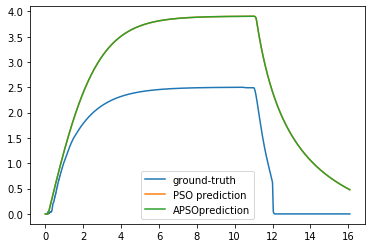

In [88]:
t = t0
u = u0
v = v0
test1 = ev_func(t, u, pso_best)
test2 = ev_func(t, u, apso_best)
#test3 = ev_func(t, u, bso_best)
plt.plot(t, v, label='ground-truth')
plt.plot(t, test1, label='PSO prediction')
plt.plot(t, test2, label='APSOprediction')
#plt.plot(t, test3, label='BSOprediction')
plt.legend()
plt.show()

## Result Comparison

In [79]:
t = [t0, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11]
u = [u0, u1, u2, u3, u4, u5, u6, u7, u8, u9, u10, u11]
v = [v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11]

### PSO Algorithm

In [80]:
pso_acc = []
pso_mse = []
pso_maae = []
for i in range(len(t)):
    pso_acc.append(accuracy(t[i], u[i], v[i], pso_best))
    pso_mse.append(mean_squared_error(t[i], u[i], v[i], pso_best))
    pso_maae.append(maximum_absolute_error(t[i], u[i], v[i], pso_best))

In [81]:
print('Accuracy')
for i in range(len(t)):
    print('Data-{}: {:.2f}%'.format(i+1, pso_acc[i]*100))

Accuracy
Data-1: -15.84%
Data-2: 78.31%
Data-3: 83.21%
Data-4: 69.07%
Data-5: 74.45%
Data-6: 68.13%
Data-7: 81.69%
Data-8: 82.01%
Data-9: 0.38%
Data-10: 65.06%
Data-11: 40.56%
Data-12: 46.67%


In [82]:
print('Mean Squared Error')
for i in range(len(t)):
    print('Data-{}: {:.5f}'.format(i+1, pso_mse[i]))

Mean Squared Error
Data-1: 1.51682
Data-2: 0.56834
Data-3: 0.30524
Data-4: 1.93359
Data-5: 1.45932
Data-6: 0.75156
Data-7: 0.87879
Data-8: 1.01905
Data-9: 1.01700
Data-10: 0.42452
Data-11: 1.17417
Data-12: 1.13217


In [83]:
print('Maximum Absolute Squared Error')
for i in range(len(t)):
    print('Data-{}: {:.3f}'.format(i+1, pso_maae[i]))

Maximum Absolute Squared Error
Data-1: 2.325
Data-2: 2.357
Data-3: 2.246
Data-4: 8.637
Data-5: 5.035
Data-6: 1.745
Data-7: 2.554
Data-8: 3.226
Data-9: 1.186
Data-10: 1.708
Data-11: 2.309
Data-12: 1.740


### APSO Algorithm

In [84]:
apso_acc = []
apso_mse = []
apso_maae = []
for i in range(len(t)):
    apso_acc.append(accuracy(t[i], u[i], v[i], apso_best))
    apso_mse.append(mean_squared_error(t[i], u[i], v[i], apso_best))
    apso_maae.append(maximum_absolute_error(t[i], u[i], v[i], apso_best))

In [85]:
print('Accuracy')
for i in range(len(t)):
    print('Data-{}: {:.2f}%'.format(i+1, apso_acc[i]*100))

Accuracy
Data-1: -15.83%
Data-2: 78.32%
Data-3: 83.18%
Data-4: 68.95%
Data-5: 74.43%
Data-6: 68.15%
Data-7: 81.67%
Data-8: 82.10%
Data-9: 0.43%
Data-10: 65.12%
Data-11: 40.58%
Data-12: 46.68%


In [86]:
print('Mean Squared Error')
for i in range(len(t)):
    print('Data-{}: {:.5f}'.format(i+1, apso_mse[i]))

Mean Squared Error
Data-1: 1.51632
Data-2: 0.56784
Data-3: 0.30624
Data-4: 1.94818
Data-5: 1.46128
Data-6: 0.75065
Data-7: 0.88137
Data-8: 1.00822
Data-9: 1.01598
Data-10: 0.42323
Data-11: 1.17329
Data-12: 1.13152


In [87]:
print('Maximum Absolute Squared Error')
for i in range(len(t)):
    print('Data-{}: {:.3f}'.format(i+1, apso_maae[i]))

Maximum Absolute Squared Error
Data-1: 2.325
Data-2: 2.358
Data-3: 2.247
Data-4: 8.614
Data-5: 5.036
Data-6: 1.744
Data-7: 2.560
Data-8: 3.260
Data-9: 1.185
Data-10: 1.707
Data-11: 2.309
Data-12: 1.740


## BSO Algorithm

In [83]:
bso_acc = []
bso_mse = []
bso_maae = []
for i in range(len(t)):
    bso_acc.append(accuracy(t[i], u[i], v[i], bso_best))
    bso_mse.append(mean_squared_error(t[i], u[i], v[i], bso_best))
    bso_maae.append(maximum_absolute_error(t[i], u[i], v[i], bso_best))

In [84]:
print('Accuracy')
for i in range(len(t)):
    print('Data-{}: {:.2f}%'.format(i+1, bso_acc[i]*100))

Accuracy
Data-1: 44.53%
Data-2: 78.66%
Data-3: 84.79%
Data-4: 78.77%
Data-5: 79.03%
Data-6: 85.78%
Data-7: 83.51%
Data-8: 79.74%
Data-9: 65.54%
Data-10: 72.86%
Data-11: 66.82%
Data-12: 79.18%


In [85]:
print('Mean Squared Error')
for i in range(len(t)):
    print('Data-{}: {:.5f}'.format(i+1, bso_mse[i]))

Mean Squared Error
Data-1: 0.34778
Data-2: 0.55022
Data-3: 0.25060
Data-4: 0.91066
Data-5: 0.98359
Data-6: 0.14971
Data-7: 0.71322
Data-8: 1.29240
Data-9: 0.12169
Data-10: 0.25626
Data-11: 0.36581
Data-12: 0.17252


In [86]:
print('Maximum Absolute Squared Error')
for i in range(len(t)):
    print('Data-{}: {:.3f}'.format(i+1, bso_maae[i]))

Maximum Absolute Squared Error
Data-1: 1.782
Data-2: 2.457
Data-3: 2.288
Data-4: 2.702
Data-5: 2.210
Data-6: 1.071
Data-7: 2.353
Data-8: 3.304
Data-9: 0.687
Data-10: 2.878
Data-11: 2.082
Data-12: 0.978
